In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
import torch
torch.cuda.device_count()  # print 1

1

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob
#import wandb

import monai
from monai.losses import DiceCELoss, DiceFocalLoss, FocalLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    MapTransform,
    ScaleIntensityd,
    #AddChanneld,
    SpatialPadd,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    ConcatItemsd,
    AdjustContrastd, 
    Rand3DElasticd,
    HistogramNormalized,
    NormalizeIntensityd

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

from monai.utils import first, set_determinism
from sklearn.model_selection import train_test_split

#from unest_network.unest import UNesT

import torch

print_config()

MONAI version: 1.3.0
Numpy version: 1.24.4
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/miniconda3/envs/clam/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 10.0.1
Tensorboard version: 2.14.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about i

In [3]:
# set_determinism(seed=1024)
# wandb.init(project="hecktor2022-SGD-1000-epochs")

In [2]:
import pandas as pd
import shutil

# Paths of CSV files for the seven centers
csv_files = {
    'CHUM': '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM_test.csv',
    'CHUP': '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUP_test.csv',
    'CHUS': '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUS_test.csv',
    'CHUV': '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUV_test.csv',
    'HGJ': '/home/nada.saadi/MIS-FM/hecktor2022_cropped/HGJ_test.csv',
    'HMR': '/home/nada.saadi/MIS-FM/hecktor2022_cropped/HMR_test.csv',
    'MDA': '/home/nada.saadi/MIS-FM/hecktor2022_cropped/MDA_test.csv'
}
# Paths of CSV files for the seven centers

# List to store all CT scan paths
all_ct_scans = []

# Iterate over each CSV file and extract CT scan paths
for center, file_path in csv_files.items():
    try:
        # Read the CSV file, assuming the paths are in the first column
        df = pd.read_csv(file_path, header=None)
        ct_scan_paths = df[0].tolist()

        # Append these paths to the all_ct_scans list
        all_ct_scans.extend(ct_scan_paths)
    except FileNotFoundError:
        print(f"File not found: {file_path}")

# Print the combined list of CT scan paths
print(f"Total number of CT scans: {len(all_ct_scans)}")
print("First few CT scan paths:", all_ct_scans[:5])  # Print first few paths for verification

# Directory where you want to save the CT scans
destination_dir = '/home/nada.saadi/MIS-FM/net/all_ct_scans'
os.makedirs(destination_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Copy each CT scan to the new directory
for ct_scan_path in all_ct_scans:
    try:
        # Extract the file name from the path
        file_name = os.path.basename(ct_scan_path)
        destination_path = os.path.join(destination_dir, file_name)

        # Copy the file to the destination directory
        shutil.copy(ct_scan_path, destination_path)
        print(f"Copied {ct_scan_path} to {destination_path}")
    except FileNotFoundError:
        print(f"File not found: {ct_scan_path}")
os.makedirs(destination_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Copy each CT scan to the new directory
for ct_scan_path in all_ct_scans:
    # Extract the file name from the path
    file_name = os.path.basename(ct_scan_path)
    destination_path = os.path.join(destination_dir, file_name)
    
    # Copy the file to the destination directory
    shutil.copy(ct_scan_path, destination_path)
    print(f"Copied {ct_scan_path} to {destination_path}")

print("All CT scans have been copied to the new directory.")


Total number of CT scans: 529
First few CT scan paths: ['CT Scan File Path', '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-044/CHUM-044_ct.nii.gz', '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-033/CHUM-033_ct.nii.gz', '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-039/CHUM-039_ct.nii.gz', '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-001/CHUM-001_ct.nii.gz']
File not found: CT Scan File Path
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-044/CHUM-044_ct.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-033/CHUM-033_ct.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-039/CHUM-039_ct.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-001/CHUM-001_ct.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-057/CHUM-057_ct.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-018/CHUM-018_ct.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/C

FileNotFoundError: [Errno 2] No such file or directory: 'CT Scan File Path'

In [3]:
import os
import pandas as pd
import shutil

# Paths to the CSV files
csv_files = [
    '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM_gt_test.csv',
    '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUP_gt_test.csv',
    '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUS_gt_test.csv',
    '/home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUV_gt_test.csv',
    '/home/nada.saadi/MIS-FM/hecktor2022_cropped/HGJ_gt_test.csv',
    '/home/nada.saadi/MIS-FM/hecktor2022_cropped/HMR_gt_test.csv',
    '/home/nada.saadi/MIS-FM/hecktor2022_cropped/MDA_gt_test.csv'
]

# Destination directory for the GT scans
destination_dir = '/home/nada.saadi/MIS-FM/net/all_gt_scans'
os.makedirs(destination_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Process each CSV file
for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file, header=None)  # Assuming no header in the CSV
        gt_scans = df[0].tolist()  # Assuming paths are in the first column

        # Copy each GT scan to the new directory
        for gt_scan_path in gt_scans:
            try:
                file_name = os.path.basename(gt_scan_path)
                destination_path = os.path.join(destination_dir, file_name)

                shutil.copy(gt_scan_path, destination_path)
                print(f"Copied {gt_scan_path} to {destination_path}")
            except FileNotFoundError:
                print(f"File not found: {gt_scan_path}")

        print("All GT scans have been copied to the new directory.")
    except FileNotFoundError:
        print(f"File not found: {csv_file}")
for csv_file in csv_files:
    df = pd.read_csv(csv_file, header=None)  # Assuming no header in the CSV
    gt_scans = df[0].tolist()  # Assuming paths are in the first column

    # Copy each GT scan to the new directory
    for gt_scan_path in gt_scans:
        file_name = os.path.basename(gt_scan_path)
        destination_path = os.path.join(destination_dir, file_name)

        shutil.copy(gt_scan_path, destination_path)
        print(f"Copied {gt_scan_path} to {destination_path}")

print("All GT scans have been copied to the new directory.")


File not found: Ground Truth File Path
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-044/CHUM-044_gt.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-033/CHUM-033_gt.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-039/CHUM-039_gt.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-001/CHUM-001_gt.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-057/CHUM-057_gt.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-018/CHUM-018_gt.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-012/CHUM-012_gt.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-065/CHUM-065_gt.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-062/CHUM-062_gt.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-015/CHUM-015_gt.nii.gz
File not found: /home/nada.saadi/MIS-FM/hecktor2022_cropped/CHUM-027/CHUM-027_gt.

FileNotFoundError: [Errno 2] No such file or directory: 'Ground Truth File Path'

In [3]:

import os
import glob
from sklearn.model_selection import train_test_split

ct_path = '/home/nada.saadi/MIS-FM/net/all_ct_scans'
gt_path = '/home/nada.saadi/MIS-FM/net/all_gt_scans'
#pt_path = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/pt'
ct = sorted(glob.glob(os.path.join(ct_path, "*ct*.nii.gz")))
#pt = sorted(glob.glob(os.path.join(pt_path, "*pt*.nii.gz"))) 
gt = sorted(glob.glob(os.path.join(gt_path, "*gt*.nii.gz"))) 
#pt = sorted(glob(os.path.join(pt_path, "*pt*.nii.gz"))) 
gt = sorted(glob.glob(os.path.join(gt_path, "*gt*.nii.gz"))) 

print(len(ct))  

ct_train, ct_test, seg_train, seg_test = train_test_split(ct,gt, test_size=0.15, random_state=1024)

train_files = [{"ct": ct_in,  "seg": gt_in} for ct_in, gt_in in zip(ct_train,seg_train)]
test_files = [{"ct": ct_in,  "seg": gt_in} for ct_in, gt_in in zip(ct_test, seg_test)]


train_files = train_files+test_files

print(len(gt))

520
520


TypeError: Invalid shape (200,) for image data

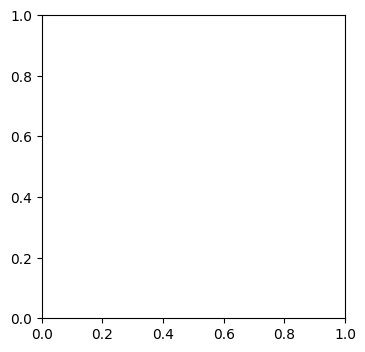

In [6]:
from skimage import measure

gt = monai.transforms.LoadImage(ensure_channel_first=True)('/home/nada.saadi/CTPET/hecktor2022_cropped/data/HGJ-087/HGJ-087_gt.nii.gz')

plt.figure("image", (18, 10))
gt = monai.transforms.Orientation(axcodes='RAS')(gt[0])
plt.subplot(2, 4, 1)
plt.imshow(gt[0,:,118], cmap='gray')
print(gt.shape)

contours = measure.find_contours(gt[0,:,:,118], 0.5)[0]
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)('/home/nada.saadi/CTPET/hecktor2022_cropped/data/HGJ-087/HGJ-087_ct.nii.gz')
ct = monai.transforms.Orientation(axcodes='RAS')(ct[0])
ct = torch.clip(ct, min=-1000, max=600)
plt.subplot(2, 4, 2)
plt.imshow(ct[0,:,118], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

TypeError: Invalid shape (200, 200, 295) for image data

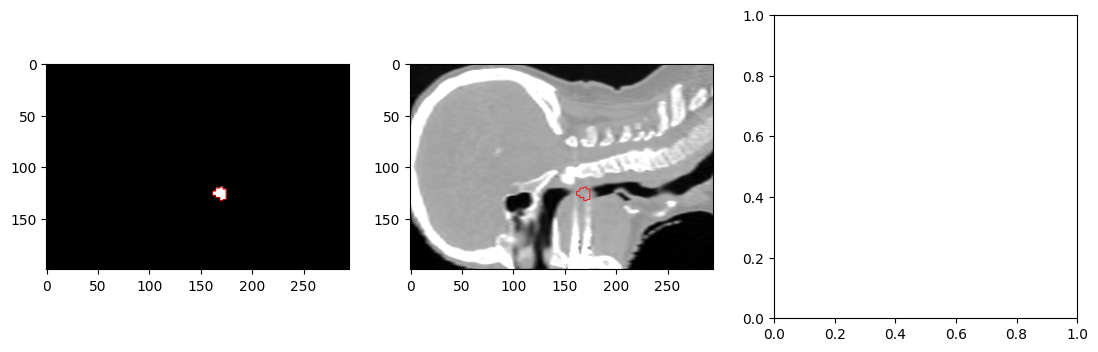

In [8]:
import matplotlib.pyplot as plt
from skimage import measure

gt_path = '/home/nada.saadi/CTPET/hecktor2022_cropped/data/HGJ-087/HGJ-087_gt.nii.gz'
ct_path = '/home/nada.saadi/CTPET/hecktor2022_cropped/data/HGJ-087/HGJ-087_ct.nii.gz'

gt = monai.transforms.LoadImage(ensure_channel_first=True)(gt_path)
gt = monai.transforms.Orientation(axcodes='RAS')(gt[0])
gt = gt[100, :, :]
plt.figure("image", (18, 10))
plt.subplot(2, 4, 1)
plt.imshow(gt, cmap='gray')
contours = measure.find_contours(gt, 0.5)[0]
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red', alpha=0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)(ct_path)
ct = monai.transforms.Orientation(axcodes='RAS')(ct[0])
ct = torch.clip(ct, min=-1000, max=600)
ct = ct[100, :, :]
plt.subplot(2, 4, 2)
plt.imshow(ct, cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red', alpha=0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)(ct_path)
ct = monai.transforms.Orientation(axcodes='RAS')(ct)
ct = torch.clip(ct, min=-300, max=300)
ct = ct[0, :, :]
plt.subplot(2, 4, 3)
plt.imshow(ct, cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red', alpha=0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)(ct_path)
ct = monai.transforms.Orientation(axcodes='RAS')(ct)
ct = torch.clip(ct, min=-200, max=200)
ct = ct[0, :, :]
plt.subplot(2, 4, 4)
plt.imshow(ct, cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red', alpha=0.8)

pt = monai.transforms.LoadImage(ensure_channel_first=True)('/home/nada.saadi/CTPET/hecktor2022_cropped/data/HGJ-087/HGJ-087_pt.nii.gz')
pt = monai.transforms.Orientation(axcodes='PLS')(pt)
plt.subplot(2, 4, 5)
plt.imshow(pt[:, :, 75], cmap='gray')
if len(contours) > 0:
   plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red', alpha=0.8)

fm = ct>0
pt = np.clip(pt, pt.min(), 5)
PTfm = pt*fm

plt.subplot(2, 4, 6)
plt.imshow(fm[:, :, 75], cmap='gray')
if len(contours) > 0:
   plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red', alpha=0.8)

plt.subplot(2, 4, 7)
plt.imshow(PTfm[:, :, 75], cmap='gray')
if len(contours) > 0:
   plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red', alpha=0.8)

plt.subplot(2, 4, 8)
pt = np.sin(pt)
pt = monai.transforms.NormalizeIntensity()(pt)
plt.imshow(pt[:, :, 75], cmap='gray')




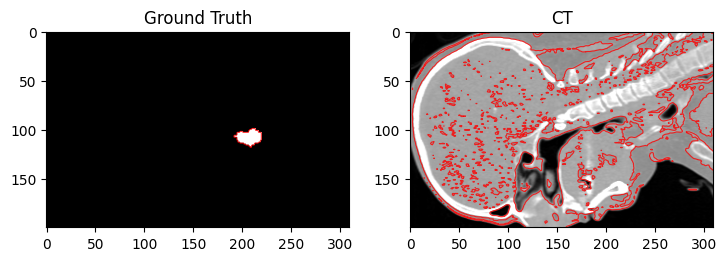

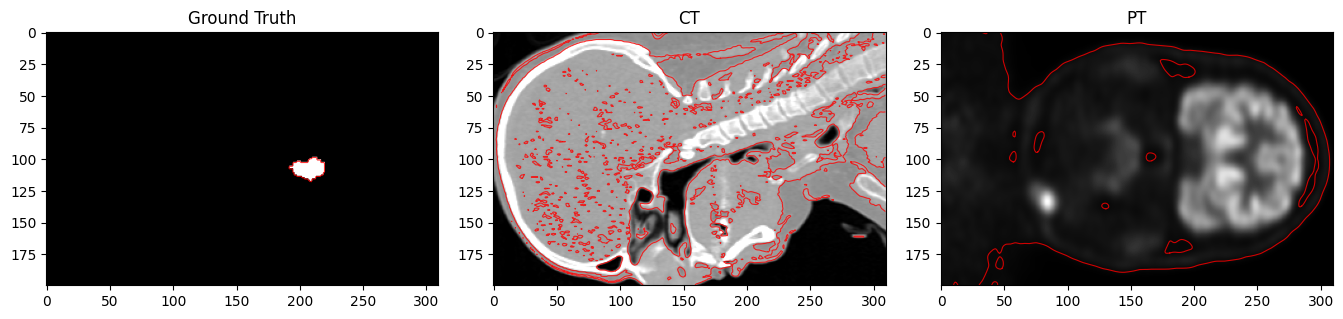

In [11]:
import monai
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from collections.abc import Sequence

from unetr import CustomedUNETR
from monai.networks.nets import UNETR
# Load the pretrained weights
#pretrained_weights = torch.load('/home/nada.saadi/CTPET/hecktor2022_cropped/4centers-ctonly/4centers-ctonly.pth')


model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072, 
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

model_path = '/home/nada.saadi/CTPET/hecktor2022_cropped/c_6th_ctpt/c_6th_ctptct.pth'

model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()
# Assuming monai and torch are already imported and configured
gt_path = '/home/nada.saadi/CTPET/hecktor2022_cropped/data/CHUP-070/CHUP-070_gt.nii.gz'
ct_path = '/home/nada.saadi/CTPET/hecktor2022_cropped/data/CHUP-070/CHUP-070_ct.nii.gz'
pt_path = '/home/nada.saadi/CTPET/hecktor2022_cropped/data/CHUP-070/CHUP-070_pt.nii.gz'

# Load and preprocess the ground truth and CT images
gt = monai.transforms.Compose([
    monai.transforms.LoadImage(image_only=True),
    #monai.transforms.AddChannel(),
    monai.transforms.Orientation(axcodes='RAS')
])(gt_path)

ct = monai.transforms.Compose([
    monai.transforms.LoadImage(image_only=True),
    #monai.transforms.AddChannel(),
    monai.transforms.Orientation(axcodes='RAS'),
    lambda x: torch.clip(x, -1000, 600)  # Adjust the clipping values as needed
])(ct_path)

# Load and preprocess the PT image
pt = monai.transforms.Compose([
    monai.transforms.LoadImage(image_only=True),
    #monai.transforms.AddChannel(),
    monai.transforms.Orientation(axcodes='PLS'),  # Adjust axcodes if necessary
])(pt_path)

# Define a generic plot function
def plot_slice_with_contours(ax, image, level=0.5, title=""):
    ax.imshow(image, cmap='gray')
    contours = measure.find_contours(image, level)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.8, c='red', alpha=0.8)
    ax.set_title(title)

# Visualization
plt.figure(figsize=(18, 10))
slices = [100, 100]  # Example slices for CT and PT, adjust as necessary

# Ground truth and CT slices
plot_slice_with_contours(plt.subplot(2, 4, 1), gt[slices[0], :, :], title="Ground Truth")
plot_slice_with_contours(plt.subplot(2, 4, 2), ct[slices[0], :, :], title="CT")

def plot_slice_with_contours(ax, image, level=0.5, title=""):
    ax.imshow(image, cmap='gray')
    contours = measure.find_contours(image, level)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.8, c='red', alpha=0.8)
    ax.set_title(title)

# Visualization
plt.figure(figsize=(18, 10))
slices = [100, 75]  # Example slices for CT and PT, adjust as necessary

# Ground truth and CT slices
plot_slice_with_contours(plt.subplot(2, 4, 1), gt[slices[0], :, :], title="Ground Truth")
plot_slice_with_contours(plt.subplot(2, 4, 2), ct[slices[0], :, :], title="CT")
# Adding PT visualization
plot_slice_with_contours(plt.subplot(2, 4, 3), pt[:, :, slices[1]], title="PT")  # Assuming coronal slice for PT

plt.tight_layout()  # Optional: Improves the layout

# Further CT adjustments and PT visualization could follow a similar structure
# ...

plt.show()


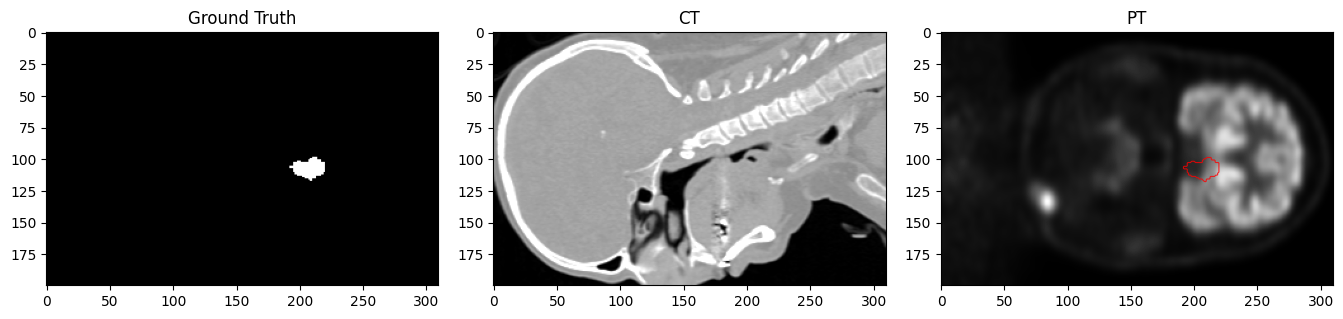

In [12]:


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from collections.abc import Sequence

from unetr import CustomedUNETR
from monai.networks.nets import UNETR
# Load the pretrained weights
#pretrained_weights = torch.load('/home/nada.saadi/CTPET/hecktor2022_cropped/4centers-ctonly/4centers-ctonly.pth')


model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072, 
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

model_path = '/home/nada.saadi/CTPET/hecktor2022_cropped/c_6th_ctpt/c_6th_ctptct.pth'

model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()
def plot_slice_with_contours(ax, image, mask=None, level=0.5, title=""):
    """Plot slice with optional contours from a mask.
    
    Args:
        ax (matplotlib.axes.Axes): The axes on which to plot.
        image (numpy.ndarray): The image to plot.
        mask (numpy.ndarray, optional): The mask from which to draw contours.
        level (float, optional): The level at which to find contours in the mask.
        title (str, optional): The title for the subplot.
    """
    ax.imshow(image, cmap='gray')
    if mask is not None:
        # Find contours in the mask and plot them on the image
        contours = measure.find_contours(mask, level)
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=0.8, c='red', alpha=0.8)
    ax.set_title(title)

# Assuming `gt` is a binary mask where the tumor region(s) is(are) marked,
# you can directly pass it to the plotting function for the PT scan.
# Make sure `gt` is properly aligned and registered with the PT scan.

plt.figure(figsize=(18, 10))
slices = [100, 75]  # Example slices for CT and PT, adjust as necessary

# Plot Ground truth, CT, and PT with tumor contours from GT
plot_slice_with_contours(plt.subplot(2, 4, 1), gt[slices[0], :, :], title="Ground Truth")
plot_slice_with_contours(plt.subplot(2, 4, 2), ct[slices[0], :, :], title="CT")
# For PT, use the GT mask to draw contours
plot_slice_with_contours(plt.subplot(2, 4, 3), pt[:, :, slices[1]], mask=gt[slices[0], :, :], title="PT")

plt.tight_layout()
plt.show()

In [5]:
gt = monai.transforms.LoadImage(ensure_channel_first=True)(gt_path)
gt = monai.transforms.Orientation(axcodes='RAS')(gt[0])
gt.shape

torch.Size([200, 200, 310])

In [6]:
gt.shape

torch.Size([200, 200, 310])

In [ ]:
contours = measure.find_contours(gt, 0.5)[0]

In [7]:
class ClipCT(MapTransform):
    """
    Convert labels to multi channels based on hecktor classes:
    label 1 is the tumor
    label 2 is the lymph node

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key == "ct":
                d[key] = torch.clip(d[key], min=-200, max=200)
            elif key == "pt":
                d[key] = torch.clip(d[key], d[key].min(), 5)
        return d
# class MulPTFM(MapTransform):
#     """
#     Mult PT and FM 

#     """

#     def __call__(self, data):
#         d = dict(data)

#         fm = d["ct"] > 0
#         d["pt"] = d["pt"] * fm
#         return d

In [27]:
from monai.transforms import NormalizeIntensityd
import monai.transforms as transforms

class ClipCT(transforms.MapTransform):
    """
    Convert labels to multi channels based on hecktor classes:
    label 1 is the tumor
    label 2 is the lymph node
    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key == "ct":
                d[key] = torch.clip(d[key], min=-200, max=200)
            elif key == "pt":
                d[key] = torch.clip(d[key], d[key].min(), 5)
        return d

# class MulPTFM(transforms.MapTransform):
#     """
#     Mult PT and FM 
#     """

#     def __call__(self, data):
#         d = dict(data)
#         fm = d["ct"] > 0
#         #d["pt"] = d["pt"] * fm
#         return d

num_samples = 4

train_transforms = Compose(
    [
        LoadImaged(keys=["ct", "seg"], ensure_channel_first=True),
        SpatialPadd(keys=["ct", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "seg"], axcodes="PLS"),
        # NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        # MulPTFM(keys=["ct","pt"]),
        # ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        # NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["ct", "seg"],
            label_key="seg",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="ct",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[0],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[1],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[2],
            prob=0.20,
        ),
        RandRotate90d(
            keys=["ct", "seg"],
            prob=0.20,
            max_k=3,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "seg"], ensure_channel_first=True),
        SpatialPadd(keys=["ct", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct", "seg"], axcodes="PLS"),
        # NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        # MulPTFM(keys=["ct","pt"]),
        # ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
    ]
)

# train_transforms = transforms.Compose(
#     [
#         transforms.LoadImaged(keys=["ct", "seg"], ensure_channel_first=True),
#         transforms.SpatialPadd(keys=["ct", "seg"], spatial_size=(200, 200, 310), method='end'),
#         transforms.Orientationd(keys=["ct", "seg"], axcodes="RAS"),
#         ClipCT(keys=["ct"]),
#         #MulPTFM(keys=["ct"]),
#         transforms.ConcatItemsd(keys=["ct"], name="ct"),
#         transforms.NormalizeIntensityd(keys=["ct"], channel_wise=True),

#         transforms.RandFlipd(
#             keys=["ct", "seg"],
#             spatial_axis=[0],
#             prob=0.20,
#         ),
#         transforms.RandFlipd(
#             keys=["ct", "seg"],
#             spatial_axis=[1],
#             prob=0.20,
#         ),
#         transforms.RandFlipd(
#             keys=["ct", "seg"],
#             spatial_axis=[2],
#             prob=0.20,
#         ),
#         transforms.RandRotate90d(
#             keys=["ct", "seg"],
#             prob=0.20,
#             max_k=3,
#         ),
#     ]
# )
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["ct","seg"], ensure_channel_first = True),
#         SpatialPadd(keys=["ct","seg"], spatial_size=(200,200,310), method='end'),
#         Orientationd(keys=["ct","seg"], axcodes="PLS"),
#         ClipCT(keys=["ct"]),
#         #MulPTFM(keys=["ct"]),
#         #ConcatItemsd(keys=["ct"], name="ctpt"),
#         NormalizeIntensityd(keys=["ct"], channel_wise=True),
#     ]
# )

# val_ds = CacheDataset(
#     data=test_files, transform=train_transforms, cache_num=6, num_workers=4
# )

In [18]:
from torch.utils.data import DataLoader
# create a training data loader
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
# create a training data loader
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
)


train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
# create a validation data loader
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
)
pin_memory=torch.cuda.is_available(),



# create a validation data loader
val_ds = monai.data.Dataset(data=test_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=4)

In [10]:
a=next(iter(train_loader))
a['ct'].shape

torch.Size([8, 1, 200, 200, 310])

image shape: torch.Size([1, 200, 200, 310]), label shape: torch.Size([1, 200, 200, 310])


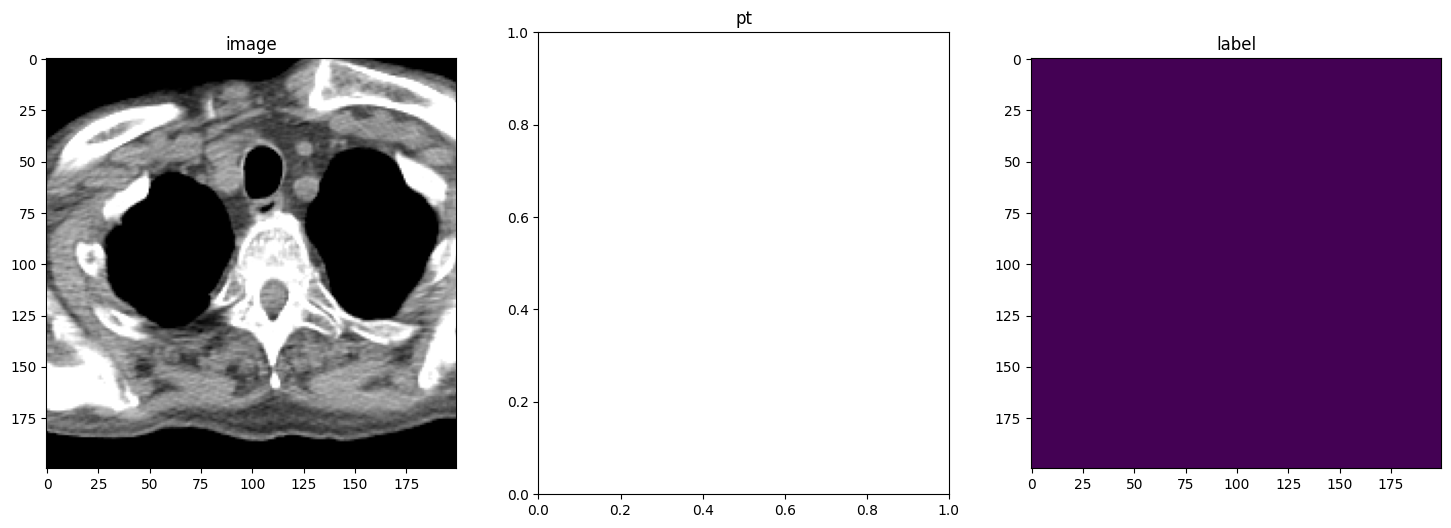

In [11]:
case = val_ds[5]
img = case["ct"]
#pt = case["ctpt"]
label = case["seg"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)

plt.title("image")
plt.imshow(img[0, :, :, 40].detach().cpu(), cmap="gray")
plt.subplot(1, 3, 2)
plt.title("pt")
#plt.imshow(pt[0, :, :, 40].detach().cpu(), cmap="gray")
plt.subplot(1, 3, 3)
plt.title("label")
plt.imshow(label[0, :, :, 40].detach().cpu())

In [12]:
import torch 

import os
from monai.networks.nets import SwinUNETR
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=3,
    feature_size=48,
    use_checkpoint=True,
).to(device)

# model = UNesT(
#     img_size=(96, 96, 96),
#     in_channels=2,
#     out_channels=3,
#     feature_size= 16,
#     norm_name= "batch"
# ).to(device)

# model = monai.networks.nets.SegResNet(
#     blocks_down=[1, 2, 2, 4],
#     blocks_up=[1, 1, 1],
#     init_filters=16,
#     in_channels=2,
#     out_channels=3,
#     dropout_prob=0.2,
# ).to(device)

# model = UTNetV2(in_chan=2, num_classes=3).to(device)

In [13]:
torch.backends.cudnn.benchmark = True
def poly_lr(epoch, max_epochs, initial_lr, exponent=0.9):
    return initial_lr * (1 - epoch / max_epochs)**exponent

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-5, momentum = 0.99)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [26]:
model_dir = "/home/nada.saadi/MIS-FM/net/all_ct_scans"

# train_transforms = Compose(
#     [
#         LoadImaged(keys=["ct", "seg"], ensure_channel_first=True),
#         SpatialPadd(keys=["ct", "seg"], spatial_size=(200, 200, 310), method='end'),
#         Orientationd(keys=["ct", "seg"], axcodes="PLS"),
#         # NormalizeIntensityd(keys=["pt"]),
#         ClipCT(keys=["ct"]),
#         ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
#         # MulPTFM(keys=["ct","pt"]),
#         # ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
#         # NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
#         RandCropByPosNegLabeld(
#             keys=["ct", "seg"],
#             label_key="seg",
#             spatial_size=(96, 96, 96),
#             pos=1,
#             neg=1,
#             num_samples=num_samples,
#             image_key="ct",
#             image_threshold=0,
#         ),
#         RandFlipd(
#             keys=["ct", "seg"],
#             spatial_axis=[0],
#             prob=0.20,
#         ),
#         RandFlipd(
#             keys=["ct", "seg"],
#             spatial_axis=[1],
#             prob=0.20,
#         ),
#         RandFlipd(
#             keys=["ct", "seg"],
#             spatial_axis=[2],
#             prob=0.20,
#         ),
#         RandRotate90d(
#             keys=["ct", "seg"],
#             prob=0.20,
#             max_k=3,
#         ),
#     ]
# )
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["ct", "seg"], ensure_channel_first=True),
#         SpatialPadd(keys=["ct", "seg"], spatial_size=(200, 200, 310), method='end'),
#         Orientationd(keys=["ct", "seg"], axcodes="PLS"),
#         # NormalizeIntensityd(keys=["pt"]),
#         ClipCT(keys=["ct"]),
#         ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
#         # MulPTFM(keys=["ct","pt"]),
#         # ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
#     ]
# )

print("training started", ct.shape)


def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad(): 
        
        if len(epoch_iterator_val) == 0:
            return 0, 0, 0  
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["ct"].cuda(), batch["seg"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)  # Updated window size
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice_metric_batch(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        metric_batch_val = dice_metric_batch.aggregate()

        metric_tumor = metric_batch_val[0].item()
        metric_lymph = metric_batch_val[1].item()

        dice_metric.reset()
        dice_metric_batch.reset()
    return mean_dice_val, metric_tumor, metric_lymph


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch[0]["ct"].cuda(), batch[0]["seg"].cuda())
        print('x', x.shape)

        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val, metric_tumor, metric_lymph = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            metric_values_tumor.append(metric_tumor)
            metric_values_lymph.append(metric_lymph)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
            
                torch.save(
                    model.state_dict(), os.path.join(model_dir, "best_metric_segresnet.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val, metric_tumor, metric_lymph
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val,  metric_tumor, metric_lymph
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

#print("after training", ct.shape)
max_iterations = 18000
eval_num = 100

post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

epoch = 0
max_num_epochs = 530

global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
metric_values_tumor = []
metric_values_lymph = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
    # wandb.log({'learning_rate': optimizer.param_groups[0]['lr']})
    # wandb.log({'Best Dice': dice_val_best})
    epoch += 1
    #optimizer.param_groups[0]['lr'] = poly_lr(epoch, max_num_epochs, 0.005676 , 0.9)
model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_luck_UNETr_prompt.pth")))

training started torch.Size([200, 200, 310])


Training (X / X Steps) (loss=X.X):   0%|          | 0/65 [00:00<?, ?it/s]

x torch.Size([8, 1, 96, 96, 96])


Training (0 / 18000 Steps) (loss=0.69309):   2%|▏         | 1/65 [00:09<10:16,  9.64s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (1 / 18000 Steps) (loss=0.70752):   3%|▎         | 2/65 [00:13<06:29,  6.18s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (2 / 18000 Steps) (loss=0.69931):   5%|▍         | 3/65 [00:17<05:15,  5.08s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (3 / 18000 Steps) (loss=0.63883):   6%|▌         | 4/65 [00:20<04:38,  4.56s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (4 / 18000 Steps) (loss=0.70548):   8%|▊         | 5/65 [00:24<04:16,  4.28s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (5 / 18000 Steps) (loss=0.75624):   9%|▉         | 6/65 [00:28<04:02,  4.10s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (6 / 18000 Steps) (loss=0.71629):  11%|█         | 7/65 [00:32<03:51,  4.00s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (7 / 18000 Steps) (loss=0.70562):  12%|█▏        | 8/65 [00:36<03:43,  3.93s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (8 / 18000 Steps) (loss=0.68623):  14%|█▍        | 9/65 [00:38<03:11,  3.42s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (9 / 18000 Steps) (loss=0.71599):  15%|█▌        | 10/65 [00:40<02:41,  2.93s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (10 / 18000 Steps) (loss=0.67612):  17%|█▋        | 11/65 [00:42<02:20,  2.60s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (11 / 18000 Steps) (loss=0.69464):  18%|█▊        | 12/65 [00:43<02:05,  2.36s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (12 / 18000 Steps) (loss=0.70593):  20%|██        | 13/65 [00:45<01:54,  2.20s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (13 / 18000 Steps) (loss=0.71520):  22%|██▏       | 14/65 [00:47<01:46,  2.09s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (14 / 18000 Steps) (loss=0.70499):  23%|██▎       | 15/65 [00:49<01:40,  2.02s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (15 / 18000 Steps) (loss=0.72445):  25%|██▍       | 16/65 [00:51<01:36,  1.96s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (16 / 18000 Steps) (loss=0.68147):  26%|██▌       | 17/65 [00:53<01:32,  1.92s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (17 / 18000 Steps) (loss=0.72809):  28%|██▊       | 18/65 [00:56<01:54,  2.44s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (18 / 18000 Steps) (loss=0.73135):  29%|██▉       | 19/65 [01:00<02:11,  2.85s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (19 / 18000 Steps) (loss=0.73437):  31%|███       | 20/65 [01:04<02:20,  3.13s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (20 / 18000 Steps) (loss=0.71148):  32%|███▏      | 21/65 [01:08<02:26,  3.33s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (21 / 18000 Steps) (loss=0.70113):  34%|███▍      | 22/65 [01:11<02:28,  3.46s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (22 / 18000 Steps) (loss=0.80021):  35%|███▌      | 23/65 [01:15<02:29,  3.56s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (23 / 18000 Steps) (loss=0.71267):  37%|███▋      | 24/65 [01:19<02:29,  3.63s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (24 / 18000 Steps) (loss=0.70413):  38%|███▊      | 25/65 [01:23<02:27,  3.68s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (25 / 18000 Steps) (loss=0.70418):  40%|████      | 26/65 [01:25<02:02,  3.13s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (26 / 18000 Steps) (loss=0.74580):  42%|████▏     | 27/65 [01:26<01:44,  2.75s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (27 / 18000 Steps) (loss=0.75942):  43%|████▎     | 28/65 [01:28<01:31,  2.48s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (28 / 18000 Steps) (loss=0.72408):  45%|████▍     | 29/65 [01:30<01:22,  2.29s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (29 / 18000 Steps) (loss=0.71969):  46%|████▌     | 30/65 [01:32<01:15,  2.16s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (30 / 18000 Steps) (loss=0.70334):  48%|████▊     | 31/65 [01:34<01:10,  2.07s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (31 / 18000 Steps) (loss=0.73937):  49%|████▉     | 32/65 [01:36<01:06,  2.00s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (32 / 18000 Steps) (loss=0.74999):  51%|█████     | 33/65 [01:38<01:02,  1.96s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (33 / 18000 Steps) (loss=0.70605):  52%|█████▏    | 34/65 [01:40<01:07,  2.18s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (34 / 18000 Steps) (loss=0.69536):  54%|█████▍    | 35/65 [01:44<01:20,  2.68s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (35 / 18000 Steps) (loss=0.70641):  55%|█████▌    | 36/65 [01:48<01:27,  3.03s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (36 / 18000 Steps) (loss=0.67904):  57%|█████▋    | 37/65 [01:52<01:30,  3.23s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (37 / 18000 Steps) (loss=0.69873):  58%|█████▊    | 38/65 [01:55<01:32,  3.42s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (38 / 18000 Steps) (loss=0.69839):  60%|██████    | 39/65 [01:59<01:32,  3.55s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (39 / 18000 Steps) (loss=0.68914):  62%|██████▏   | 40/65 [02:03<01:31,  3.64s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (40 / 18000 Steps) (loss=0.68552):  63%|██████▎   | 41/65 [02:07<01:28,  3.70s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (41 / 18000 Steps) (loss=0.70203):  65%|██████▍   | 42/65 [02:10<01:18,  3.42s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (42 / 18000 Steps) (loss=0.68325):  66%|██████▌   | 43/65 [02:12<01:04,  2.95s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (43 / 18000 Steps) (loss=0.72544):  68%|██████▊   | 44/65 [02:14<00:55,  2.62s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (44 / 18000 Steps) (loss=0.71315):  69%|██████▉   | 45/65 [02:15<00:47,  2.39s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (45 / 18000 Steps) (loss=0.67334):  71%|███████   | 46/65 [02:17<00:42,  2.23s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (46 / 18000 Steps) (loss=0.69039):  72%|███████▏  | 47/65 [02:19<00:38,  2.12s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (47 / 18000 Steps) (loss=0.71873):  74%|███████▍  | 48/65 [02:21<00:34,  2.04s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (48 / 18000 Steps) (loss=0.67193):  75%|███████▌  | 49/65 [02:23<00:31,  1.99s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (49 / 18000 Steps) (loss=0.74068):  77%|███████▋  | 50/65 [02:25<00:29,  1.95s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (50 / 18000 Steps) (loss=0.73906):  78%|███████▊  | 51/65 [02:28<00:35,  2.51s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (51 / 18000 Steps) (loss=0.70451):  80%|████████  | 52/65 [02:32<00:37,  2.91s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (52 / 18000 Steps) (loss=0.71173):  82%|████████▏ | 53/65 [02:36<00:38,  3.18s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (53 / 18000 Steps) (loss=0.70764):  83%|████████▎ | 54/65 [02:40<00:37,  3.38s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (54 / 18000 Steps) (loss=0.71258):  85%|████████▍ | 55/65 [02:44<00:35,  3.51s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (55 / 18000 Steps) (loss=0.71642):  86%|████████▌ | 56/65 [02:48<00:32,  3.61s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (56 / 18000 Steps) (loss=0.72300):  88%|████████▊ | 57/65 [02:52<00:29,  3.69s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (57 / 18000 Steps) (loss=0.70072):  89%|████████▉ | 58/65 [02:55<00:25,  3.69s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (58 / 18000 Steps) (loss=0.68825):  91%|█████████ | 59/65 [02:57<00:18,  3.14s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (59 / 18000 Steps) (loss=0.68212):  92%|█████████▏| 60/65 [02:59<00:13,  2.76s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (60 / 18000 Steps) (loss=0.72099):  94%|█████████▍| 61/65 [03:01<00:09,  2.49s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (61 / 18000 Steps) (loss=0.72962):  95%|█████████▌| 62/65 [03:03<00:06,  2.30s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (62 / 18000 Steps) (loss=0.70617):  97%|█████████▋| 63/65 [03:05<00:04,  2.17s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (63 / 18000 Steps) (loss=0.69406):  98%|█████████▊| 64/65 [03:08<00:02,  2.67s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (X / X Steps) (loss=X.X):   0%|          | 0/65 [00:00<?, ?it/s]

x torch.Size([8, 1, 96, 96, 96])


Training (65 / 18000 Steps) (loss=0.72390):   2%|▏         | 1/65 [00:11<11:59, 11.25s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (66 / 18000 Steps) (loss=0.72856):   3%|▎         | 2/65 [00:14<06:47,  6.47s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (67 / 18000 Steps) (loss=0.70491):   5%|▍         | 3/65 [00:16<04:30,  4.36s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (68 / 18000 Steps) (loss=0.69335):   6%|▌         | 4/65 [00:18<03:42,  3.64s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (69 / 18000 Steps) (loss=0.70747):   8%|▊         | 5/65 [00:22<03:43,  3.73s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (70 / 18000 Steps) (loss=0.67975):   9%|▉         | 6/65 [00:26<03:42,  3.77s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (71 / 18000 Steps) (loss=0.67953):  11%|█         | 7/65 [00:30<03:40,  3.81s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (72 / 18000 Steps) (loss=0.68661):  12%|█▏        | 8/65 [00:34<03:37,  3.82s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (73 / 18000 Steps) (loss=0.65692):  14%|█▍        | 9/65 [00:38<03:34,  3.82s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (74 / 18000 Steps) (loss=0.67529):  15%|█▌        | 10/65 [00:41<03:31,  3.84s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (75 / 18000 Steps) (loss=0.70537):  17%|█▋        | 11/65 [00:45<03:26,  3.83s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (76 / 18000 Steps) (loss=0.67343):  18%|█▊        | 12/65 [00:49<03:15,  3.69s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (77 / 18000 Steps) (loss=0.64768):  20%|██        | 13/65 [00:52<03:14,  3.74s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (78 / 18000 Steps) (loss=0.70556):  22%|██▏       | 14/65 [00:56<03:13,  3.79s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (79 / 18000 Steps) (loss=0.71180):  23%|██▎       | 15/65 [01:00<03:09,  3.79s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (80 / 18000 Steps) (loss=0.64574):  25%|██▍       | 16/65 [01:04<03:06,  3.81s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (81 / 18000 Steps) (loss=0.68126):  26%|██▌       | 17/65 [01:08<03:03,  3.83s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (82 / 18000 Steps) (loss=0.67975):  28%|██▊       | 18/65 [01:12<03:00,  3.84s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (83 / 18000 Steps) (loss=0.64564):  29%|██▉       | 19/65 [01:16<02:55,  3.82s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (84 / 18000 Steps) (loss=0.68363):  31%|███       | 20/65 [01:19<02:47,  3.73s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (85 / 18000 Steps) (loss=0.69515):  32%|███▏      | 21/65 [01:23<02:46,  3.78s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (86 / 18000 Steps) (loss=0.64711):  34%|███▍      | 22/65 [01:27<02:43,  3.80s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (87 / 18000 Steps) (loss=0.73061):  35%|███▌      | 23/65 [01:31<02:38,  3.78s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (88 / 18000 Steps) (loss=0.67738):  37%|███▋      | 24/65 [01:34<02:36,  3.81s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (89 / 18000 Steps) (loss=0.68750):  38%|███▊      | 25/65 [01:38<02:33,  3.83s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (90 / 18000 Steps) (loss=0.69257):  40%|████      | 26/65 [01:42<02:29,  3.84s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (91 / 18000 Steps) (loss=0.65283):  42%|████▏     | 27/65 [01:46<02:26,  3.86s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (92 / 18000 Steps) (loss=0.78796):  43%|████▎     | 28/65 [01:50<02:20,  3.80s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (93 / 18000 Steps) (loss=0.69196):  45%|████▍     | 29/65 [01:54<02:17,  3.82s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (94 / 18000 Steps) (loss=0.67997):  46%|████▌     | 30/65 [01:57<02:14,  3.84s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (95 / 18000 Steps) (loss=0.72174):  48%|████▊     | 31/65 [02:01<02:09,  3.80s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (96 / 18000 Steps) (loss=0.67990):  49%|████▉     | 32/65 [02:05<02:06,  3.82s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (97 / 18000 Steps) (loss=0.72937):  51%|█████     | 33/65 [02:09<02:02,  3.84s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (98 / 18000 Steps) (loss=0.69423):  52%|█████▏    | 34/65 [02:13<01:59,  3.85s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (99 / 18000 Steps) (loss=0.67328):  54%|█████▍    | 35/65 [02:17<01:55,  3.85s/it]

x torch.Size([8, 1, 96, 96, 96])


Training (100 / 18000 Steps) (loss=0.68658):  54%|█████▍    | 35/65 [02:39<02:16,  4.56s/it]


TypeError: iteration over a 0-d array

In [40]:
# from monai.transforms import AsDiscreted, Invertd, HistogramNormalized, ConcatItemsd
# from monai.transforms import Compose
# from monai.transforms import Orientationd
# from monai.transforms import SpatialPadd
# from monai.transforms import ScaleIntensityd
# import monai
# from monai.metrics import DiceMetric
# import math


# data="/home/nada.saadi/MIS-FM/net/all_ct_scans"


# # Assuming `data` is the dictionary containing the data
# # if "pt" not in data:
# #     data["pt"] = None
# #padding_size = [224, 224, 320] 
# train_transforms = Compose(
#     [
#         LoadImaged(keys=["ct", "seg"], ensure_channel_first = True),
#         SpatialPadd(keys=["ct", "seg"], spatial_size=(200, 200, 310), method='end'),
#         Orientationd(keys=["ct", "seg"], axcodes="PLS"),
#        # NormalizeIntensityd(keys=["pt"]),
#         ClipCT(keys=["ct"]),
#         ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
#         #MulPTFM(keys=["ct","pt"]),
#         #ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
#         #NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
#         RandCropByPosNegLabeld(
#             keys=["ct", "seg"],
#             label_key="seg",
#             spatial_size=(96, 96, 96),
#             pos=1,
#             neg=1,
#             num_samples=num_samples,
#             image_key="ctpt",
#             image_threshold=0,
#         ),
#         RandFlipd(
#             keys=["ctpt", "seg"],
#             spatial_axis=[0],
#             prob=0.20,
#         ),
#         RandFlipd(
#             keys=["ctpt", "seg"],
#             spatial_axis=[1],
#             prob=0.20,
#         ),
#         RandFlipd(
#             keys=["ctpt", "seg"],
#             spatial_axis=[2],
#             prob=0.20,
#         ),
#         RandRotate90d(
#             keys=["ctpt", "seg"],
#             prob=0.20,
#             max_k=3,
#         ),
#     ]
# )
# val_transforms = Compose(
#     [
#         LoadImaged(keys=["ct", "seg"], ensure_channel_first = True),
#         SpatialPadd(keys=["ct",  "seg"], spatial_size=(200, 200, 310), method='end'),
#         Orientationd(keys=["ct", "seg"], axcodes="PLS"),
#         #NormalizeIntensityd(keys=["pt"]),
#         ClipCT(keys=["ct"]),
#         ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
#         #MulPTFM(keys=["ct","pt"]),
#         #ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
#     ]
# )



# files_ds = monai.data.Dataset(data=test_files, transform=val_transforms)
# print(len(files_ds))

# val_loader = DataLoader(files_ds, batch_size=1, num_workers=4)
# root_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped'
# output_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/APredictions-unetr'

# # post_label = AsDiscrete(to_onehot=3)
# post_label = AsDiscrete(to_onehot=3)
# post_pred = Compose([
#     Invertd(
#             keys="pred",  # invert the `pred` data field, also support multiple fields
#             transform=val_transforms,
#             orig_keys="ctpt",  # get the previously applied pre_transforms information on the `img` data field,
#                               # then invert `pred` based on this information. we can use same info
#                               # for multiple fields, also support different orig_keys for different fields
#             nearest_interp=False,  # don't change the interpolation mode to "nearest" when inverting transforms
#                                    # to ensure a smooth output, then execute `AsDiscreted` transform
#             to_tensor=True,  # convert to PyTorch Tensor after inverting
#         ),
#     # AsDiscreted(keys="pred", argmax=True, to_onehot=3)
#     ])

# dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
# dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

# # Assuming you want to reorient your images to a specific orientation, such as "PLS"
# # Replace 'PLS' with the desired orientation axcodes if different
# transform = Orientationd(keys=["ct"], axcodes="RAS")



# # try:
# #     transformed_data = transform(data)
# # except RuntimeError as e:
# #     print(f"Error applying transform: {e}")

# root_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped'

# epoch_loss_values = []
# metric_values = []
# metric_values_tumor = []
# metric_values_lymph = []



# def train(global_step, train_loader, dice_val_best, global_step_best):
#     model.train()
#     epoch_loss = 0
#     step = 0
#     epoch_iterator = tqdm(
#         train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
#     )
#     for step, batch in enumerate(epoch_iterator):
#         step += 1
#         x, y = (batch["ctpt"].cuda(), batch["seg"].cuda())
#         logit_map = model(x)
#         loss = loss_function(logit_map, y)
#         loss.backward()
#         epoch_loss += loss.item()
#         optimizer.step()
#         optimizer.zero_grad()
#         epoch_iterator.set_description(
#             "Training (%d / %d Steps) (loss=%2.5f)"
#             % (global_step, max_iterations, loss)
#         )
#         if (
#             global_step % eval_num == 0 and global_step != 0
#         ) or global_step == max_iterations:
#             epoch_iterator_val = tqdm(
#                 val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
#             )
#             dice_val, metric_tumor, metric_lymph = validation(epoch_iterator_val)
#             epoch_loss /= step
#             epoch_loss_values.append(epoch_loss)
#             metric_values.append(dice_val)
#             metric_values_tumor.append(metric_tumor)
#             metric_values_lymph.append(metric_lymph)
#             if dice_val > dice_val_best:
#                 dice_val_best = dice_val
#                 global_step_best = global_step
#                 torch.save(
#                     model.state_dict(), os.path.join(root_dir, "best_metric_SegRes_PLS.pth")
#                 )
#                 print(
#                     "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
#                         dice_val_best, dice_val, metric_tumor, metric_lymph
#                     )
#                 )
#             else:
#                 print(
#                     "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
#                         dice_val_best, dice_val, metric_tumor, metric_lymph
#                     )
#                 )
#         global_step += 1

#         return global_step, dice_val_best, global_step_best

#     val_inputs, val_labels = (val_inputs.cuda(), val_labels.cuda())  # Move to GPU
#     val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, axcodes=val_inputs[0].axcodes, as_closest_canonical=True)
#     val_labels_list = decollate_batch(val_labels)
#     val_labels_convert = [
#                         ]
#     val_outputs_list = decollate_batch(val_outputs)
#     val_output_convert = [
#                             post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
#                         ]
#     dice_metric(y_pred=val_output_convert, y=val_labels_convert)
#     dice_metric_batch(y_pred=val_output_convert, y=val_labels_convert)
#     epoch_iterator_val.set_description(
#                             "Validate (%d / %d Steps)" % (global_step, 10.0)
#                         )
# mean_dice_val = dice_metric.aggregate().item() if dice_metric.count > 0 else 0  
# metric_batch_val = dice_metric_batch.aggregate() if dice_metric_batch.count > 0 else [0, 0]

# metric_tumor = metric_batch_val[0].item()
# metric_lymph = metric_batch_val[1].item()

# dice_metric.reset()
# dice_metric_batch.reset()
# return mean_dice_val, metric_tumor, metric_lymph


78


AttributeError: 'DiceMetric' object has no attribute 'count'

In [10]:
#VALIDATION

from monai.transforms import AsDiscreted, Invertd, HistogramNormalized
from monai.transforms import Compose


# ct_path = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/Testing/ct'
# pt_path = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/Testing/pt'

# ct = sorted(glob(os.path.join(ct_path, "*ct*.nii.gz")))
# pt = sorted(glob(os.path.join(pt_path, "*pt*.nii.gz")))

# print(len(ct))

# test_files = [{"ct": ct_in, "pt": pt_in} for ct_in, pt_in in zip(ct, pt)]

ct_path = '/home/nada.saadi/MIS-FM/net/all_ct_scans'
#pt_path = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/pt'
gt_path = '/home/nada.saadi/MIS-FM/net/all_gt_scans'

val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt"], ensure_channel_first = True),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        Orientationd(keys=["ctpt"], axcodes="PLS"),
        SpatialPadd(keys=["ctpt" ], spatial_size=(176,176,176), method='end'),
        ClipCT(keys="ctpt"),
        ScaleIntensityd(keys=["ctpt"], channel_wise=True),
        #SpatialPadd(keys=["ctpt", "seg"], spatial_size=(176,176,176), method='end'),
        # CenterSpatialCropd(keys=["ctpt", "seg"], roi_size=(100,100,100)),
        # AddCTPT(keys="ctpt"),
        # AddChanneld(keys="ctpt"),
    ]
)

files_ds = monai.data.Dataset(data=test_files, transform=val_transforms)
print(len(files_ds))

val_loader = DataLoader(files_ds, batch_size=1, num_workers=4)
root_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped'
output_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/Predictions-unetr'

# post_label = AsDiscrete(to_onehot=3)
post_label = AsDiscrete(to_onehot=3)
post_pred = Compose([
    Invertd(
            keys="pred",  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            orig_keys="ctpt",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            nearest_interp=False,  # don't change the interpolation mode to "nearest" when inverting transforms
                                   # to ensure a smooth output, then execute `AsDiscreted` transform
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
    # AsDiscreted(keys="pred", argmax=True, to_onehot=3)
    ])

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

# model = UNesT(
#     img_size=(96, 96, 96),
#     in_channels=2,
#     out_channels=3,
#     feature_size= 16,
#     norm_name= "batch"
# ).to(device)
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=3,
    feature_size=48,
    use_checkpoint=True,
).to(device)

model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_swinmodel_s111_in176_DiceCE_AdamW_lr_1e-4_b4.pth")))

model.eval()
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        roi_size = (96, 96, 96)
        sw_batch_size = 4

        val_inputs = (batch["ctpt"].cuda())
        batch["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, overlap=0.50,  predictor=model
        )

        val_outputs_list = decollate_batch(batch)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]


        preds = torch.argmax(val_output_convert[0]['pred'] , dim=0)
        monai.transforms.SaveImage(output_dir=output_dir, resample=False, separate_folder=False, output_postfix='seg')(preds)

NameError: name 'LoadImaged' is not defined

In [ ]:
no_aug = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/No_Aug'
randflip0 = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/RandFlipd0'
randflip1 = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/RandFlipd1'
randflip2 = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/RandFlipd2'
randrotate = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/RandRotate90d'


no = sorted(glob(os.path.join(no_aug, "*_pt_*.nii.gz")))
flip0 = sorted(glob(os.path.join(randflip0, "*_pt_*.nii.gz")))
flip1 = sorted(glob(os.path.join(randflip1, "*_pt_*.nii.gz")))
flip2 = sorted(glob(os.path.join(randflip2, "*_pt_*.nii.gz")))
rotate = sorted(glob(os.path.join(randrotate, "*_pt_*.nii.gz")))

print(len(no))



files = [{"no": no_in, "flip0": flip0_in, "flip1": flip1_in, "flip2": flip2_in, "rotate": rotate_in} for no_in, flip0_in, flip1_in, flip2_in, rotate_in in zip(no, flip0, flip1, flip2, rotate)]

In [18]:
from monai.transforms import MeanEnsembled, AsDiscrete, MapTransform, LoadImaged
from monai.networks import one_hot


post_pred = AsDiscrete(to_onehot=3)

class OneHot(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = post_pred(d[key])
        return d

ENS_transforms = Compose(
    [
        LoadImaged(keys=["no", "flip0", "flip1", "flip2", "rotate"], ensure_channel_first=True),
        OneHot(keys=["no", "flip0", "flip1", "flip2", "rotate"]),
        MeanEnsembled(keys=["no", "flip0", "flip1", "flip2", "rotate"], output_key="avg", weights=[[1,1,1], 
                                                                                                     [1,1,1],
                                                                                                     [1,1,1],
                                                                                                     [1,1,1],
                                                                                                     [1,1,1]]),
    ]
)



In [ ]:
ens_ds = CacheDataset(
    data=files, transform=ENS_transforms, cache_rate=1.0, num_workers=4
)

In [ ]:
np.unique(ens_ds[8]['avg'])

In [ ]:
test = torch.argmax(ens_ds[0]['avg'] , dim=0)
np.unique(test)

In [ ]:
output_dir = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/AVG'
for i in range(len(ens_ds)):
    preds = torch.argmax(ens_ds[i]['avg'] , dim=0)
    monai.transforms.SaveImage(output_dir=output_dir, resample=False, separate_folder=False, output_postfix='avg')(preds)